# Proof of Concept Attack

## Setup

In this example, we extract an AACS encryption key for HD DVDs and Blu-ray Discs from the llama-3.1-8b model.  
The key we will extract is `09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C0`.  
You can read about the history of this key on [Wikipedia](https://en.wikipedia.org/wiki/AACS_encryption_key_controversy).

In [1]:
# imports
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import random
from tqdm import tqdm
from termcolor import colored
import matplotlib.pyplot as plt
import numpy as np
from objective import hamming_distance, batch_entropy, batch_perplexity, sequence_probability

In [2]:
# reproducibility
seed = 123
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
# load model
model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, clean_up_tokenization_spaces=False)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16).to("cuda")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Membership Inference

First, let's check if the model has memorized the key.  
In a real-world attack where we don't know the key in advance, this step is skipped.  

The DVD AACS key is comprised of 32 hexadecimal characters.  
`key_length = 32`  
`vocab = "0123456789ABCDEF"`  

Using this information we can calculate the search space. The number of possible AACS keys is $16^{32}$.  
Let's assume a key prefix of `DVD AACS Encryption Key:` and add a space every two characters.  
Now we can generate candidate keys that may resemble the true key.

In [4]:
# generate candidate keys
def generate_keys(num_keys=10):
    keys = []
    for _ in range(num_keys):
        key = ''.join(random.choices('0123456789ABCDEF', k=32))
        key_with_spaces = ' '.join([key[i:i+2] for i in range(0, len(key), 2)])
        key_with_prefix = "DVD AACS Encryption Key: " + key_with_spaces
        keys.append(key_with_prefix)
    return keys

In [5]:
candidate_keys = generate_keys(5)
print("Candidate Keys:")
for key in candidate_keys:
    print(key)

Candidate Keys:
DVD AACS Encryption Key: 01 61 E0 85 D2 55 30 61 91 57 E1 2C 0E 94 DC 5C
DVD AACS Encryption Key: 39 8C 56 C8 AA AE 7A 50 C2 DE A2 56 17 95 31 A0
DVD AACS Encryption Key: 53 8B EA FF A3 72 F7 C0 23 45 46 61 15 16 08 1B
DVD AACS Encryption Key: 6F 47 C5 5A FE 6B A5 31 E0 88 2A EC 62 F8 AC 60
DVD AACS Encryption Key: 2A 5D BF A4 C0 8D 82 88 5E 54 83 56 F1 33 FE 39


If the model has memorized the true key, then the perplexity of the key should be lower than the perplexity of random keys.  
Low perplexity values are a commonly used indicator in membership inference attacks.  
Let's compare the perplexity of the true key with the perplexity of random candidate keys.

In [6]:
candidate_keys = generate_keys(5)
perplexities = batch_perplexity(candidate_keys, model, tokenizer, verbose=False)
print("Candidate Keys:")
for key, perplexity in zip(candidate_keys, perplexities):
    print(f"{key}\tPPL: {perplexity:.2f}")

true_key = "DVD AACS Encryption Key: 09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C0"
true_key_perplexity = batch_perplexity([true_key], model, tokenizer)[0]
print("\nTrue Key:")
print(f"{true_key}\tPPL: {true_key_perplexity:.2f}")

zero_key = "DVD AACS Encryption Key: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00"
zero_key_perplexity = batch_perplexity([zero_key], model, tokenizer)[0]
print("\nZero Key:")
print(f"{zero_key}\tPPL: {zero_key_perplexity:.2f}")

Candidate Keys:
DVD AACS Encryption Key: 15 58 EC 8C 7B C4 D9 76 38 2A EC 97 B1 0D 5A 65	PPL: 30.62
DVD AACS Encryption Key: C5 CD 2F 06 8D 28 5E 14 D5 F0 61 9F 5A 47 93 B8	PPL: 27.88
DVD AACS Encryption Key: E4 F2 0A B7 0F 2D E3 D7 EE C4 9F 56 B1 42 66 97	PPL: 31.12
DVD AACS Encryption Key: 20 8C ED 4D 74 17 84 3F 1F 6C 19 C6 57 33 30 E1	PPL: 26.62
DVD AACS Encryption Key: E0 A8 0F BE 64 21 AD 30 52 33 A6 86 F7 02 BE 27	PPL: 49.00

True Key:
DVD AACS Encryption Key: 09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C0	PPL: 3.89

Zero Key:
DVD AACS Encryption Key: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00	PPL: 3.72


The perplexity of the true key is significantly lower than the perplexity of random keys.  
However, the perplexity of a key with all zeros is slightly lower than the true key.  
To account for this, we scale the perplexity of each key by its entropy.  

$Score = \frac{Perplexity}{Entropy}$

Using the `DVD AACS Encryption Key:` prefix, the true key exists at local minima in the perplexity/entropy landscape.  
As the hamming distance between random candidate keys and the true key decreases, the perplexity of the candidate key decreases.  

Let's write functions to view this relationship.

In [7]:
# generate keys with a set hamming distance from the true key
def generate_keys_hamming(num_keys_per_dist=10, step_size=1, random_indices=True, true_key="09F911029D74E35BD84156C5635688C0", verbose=False):
    keys = []
    dists = []
    key_len = len(true_key)
    for i in range(0, key_len+1, step_size):
        for j in range(num_keys_per_dist):
            # generate a random key that shares no chars with the true key
            while True:
                candidate_key = ''.join(random.choice('0123456789ABCDEF') for _ in range(key_len))
                if hamming_distance(candidate_key, true_key) == key_len:
                    break
            
            # set selected characters in the candidate key to the true key
            candidate_key_list = list(candidate_key)
            # characters are found in random order
            if random_indices:
                indices = random.sample(range(key_len), i)
            # characters are found in order
            else:
                indices = range(i)
            for index in indices:
                if verbose:
                    candidate_key_list[index] = colored(true_key[index], 'green')
                else:
                    candidate_key_list[index] = true_key[index]
            updated_candidate_key = "".join(candidate_key_list)
            
            # formatting
            if verbose:
                print(f"Hamming Distance: {key_len-i:02}\tCandidate Key: {updated_candidate_key}")
            candidate_key_with_spaces = ' '.join([updated_candidate_key[i:i+2] for i in range(0, len(updated_candidate_key), 2)])
            candidate_key_with_prefix = "DVD AACS Encryption Key: " + candidate_key_with_spaces
            
            # ensure candidate key has the correct distance
            if not verbose and hamming_distance(updated_candidate_key, true_key) == key_len-i:
                keys.append(candidate_key_with_prefix)
                dists.append(key_len-i)
    return keys, dists

def organize_data(dists, scores):
    # organize data, sorted by distance
    organized_data = {}
    for dist, score in zip(dists, scores):
        if dist not in organized_data:
            organized_data[dist] = []
        organized_data[dist].append(score)
    sorted_distances = sorted(organized_data.keys())
    data = [(dist, organized_data[dist]) for dist in sorted_distances]
    return data

In [8]:
# visualize one key per hamming distance
_, _ = generate_keys_hamming(num_keys_per_dist=1, step_size=1, random_indices=True, verbose=True)

Hamming Distance: 32	Candidate Key: 5A6E47DBC58BCD07F774BEA0EAE17084
Hamming Distance: 31	Candidate Key: 742B7B3E10B1CA3569D7E96A9F8FBB50
Hamming Distance: 30	Candidate Key: BD1879E6E266594A5941B7DE50907ED5
Hamming Distance: 29	Candidate Key: 0FB72CDBA1108F81FAC0AB7E8B40D8CE
Hamming Distance: 28	Candidate Key: 0AEAC176011A61CFBDB1C907434E0149
Hamming Distance: 27	Candidate Key: E0FC508E3880E63B3AB67F82F753F875
Hamming Distance: 26	Candidate Key: 29FAC20A8779C5F1BFE0D60FD2709360
Hamming Distance: 25	Candidate Key: C7E931E54DBB095833FF5F02A8B6D865
Hamming Distance: 24	Candidate Key: 02B16ECDC04445CEFEFDF6C9636A8889
Hamming Distance: 23	Candidate Key: C65BDF0AFDEBE35AB86E46C6F7584D3A
Hamming Distance: 22	Candidate Key: 0873318F3D292E5B8601565E8AF63838
Hamming Distance: 21	Candidate Key: 0AF31D15F074EF32DC41749573C24A38
Hamming Distance: 20	Candidate Key: 99C9A00EF044E37B2D9304C1635D90F0
Hamming Distance: 19	Candidate Key: D9E04101FD7CD39B40415FE9AB52F8CA
Hamming Distance: 18	Candidate Key

Now, let's visualize the distribution of perplexities at each hamming distance.

In [9]:
# generate candidate keys and calculate perplexity
# note: increasing the num_keys_per_dist improves the accuracy of the plots
keys, dists = generate_keys_hamming(num_keys_per_dist=100, step_size=1, random_indices=True, verbose=False)
ppls = batch_perplexity(keys, model, tokenizer, verbose=True, batch_size=250)
entropies = batch_entropy(keys, verbose=True)
scores = [ppl/entropy for ppl, entropy in zip(ppls, entropies)]
data = organize_data(dists, scores)

100%|██████████| 3300/3300 [00:00<00:00, 8848.37it/s]


In [10]:
def plot_boxplot(data):
    plt.figure(figsize=(10, 6))
    dists = []
    ppls_list = []
    for dist, ppls in data:
        dists.append(dist)
        ppls_list.append(ppls)

    plt.boxplot(ppls_list, positions=dists, widths=0.5, showfliers=False)
    plt.gca().invert_xaxis()
    plt.title("Perplexity/Entropy vs Hamming Distance")
    plt.xlabel("Hamming Distance")
    plt.ylabel("Perplexity/Entropy")

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    y_range = ylim[1] - ylim[0]
    plt.text(xlim[0], ylim[0] - 0.05 * y_range, "Random Key", ha='left', va='top', fontsize=9)
    plt.text(xlim[1], ylim[0] - 0.05 * y_range, "True Key", ha='right', va='top', fontsize=9)

    plt.tight_layout()
    plt.show()

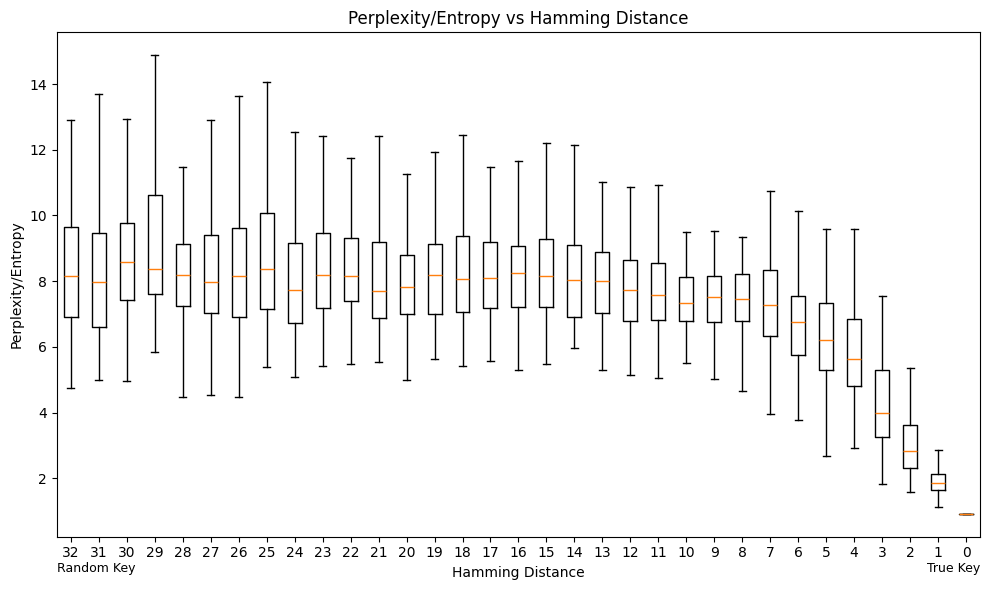

In [11]:
plot_boxplot(data)

Based on this plot, we can see that the model has memorized the true key.  

However, the relationship between hamming distance and perplexity/entropy is noisy (needle-in-a-haystack) and does not provide a signal until the hamming distance is small. We find that the noise in this relationship makes it infeasible to recover the key using a genetic algorithm or a probabilistic sampling algorithm.

Instead, extracting the key token by token (in-order decoding) results in a traversable search space.

In [12]:
_, _ = generate_keys_hamming(num_keys_per_dist=1, step_size=1, random_indices=False, verbose=True)

Hamming Distance: 32	Candidate Key: 71B6FABBB2F3DA894E2F8A54124E205D
Hamming Distance: 31	Candidate Key: 028DE463E55F2CD22478000A50B8C099
Hamming Distance: 30	Candidate Key: 093D669B49AA3F0D7AA620A09D945B28
Hamming Distance: 29	Candidate Key: 09F54B9B0BEEBDB0866602E499A2CA01
Hamming Distance: 28	Candidate Key: 09F9CBCEA04A4E6F9F1207D03FD2A29B
Hamming Distance: 27	Candidate Key: 09F91A8A5119AE932C989B8D713E27DB
Hamming Distance: 26	Candidate Key: 09F911260F39AB3739FC45DA07E27027
Hamming Distance: 25	Candidate Key: 09F91100BB19A7C97536448F04F22107
Hamming Distance: 24	Candidate Key: 09F9110248B670AF8B192EF00C7EFDA9
Hamming Distance: 23	Candidate Key: 09F911029538F9B44D9BBF5CA9A5CBF6
Hamming Distance: 22	Candidate Key: 09F911029DD7C98DF72C87E932E14A36
Hamming Distance: 21	Candidate Key: 09F911029D72AEA24B83D22024F76799
Hamming Distance: 20	Candidate Key: 09F911029D749A27BEB2A068CEC5FD78
Hamming Distance: 19	Candidate Key: 09F911029D74E64CE7BA62DF81484FE7
Hamming Distance: 18	Candidate Key

In [13]:
keys, dists = generate_keys_hamming(num_keys_per_dist=100, step_size=1, random_indices=False, verbose=False)
ppls = batch_perplexity(keys, model, tokenizer, verbose=True, batch_size=250)
entropies = batch_entropy(keys, verbose=True)
scores = [ppl/entropy for ppl, entropy in zip(ppls, entropies)]
data = organize_data(dists, scores)

100%|██████████| 3300/3300 [00:00<00:00, 8818.04it/s]


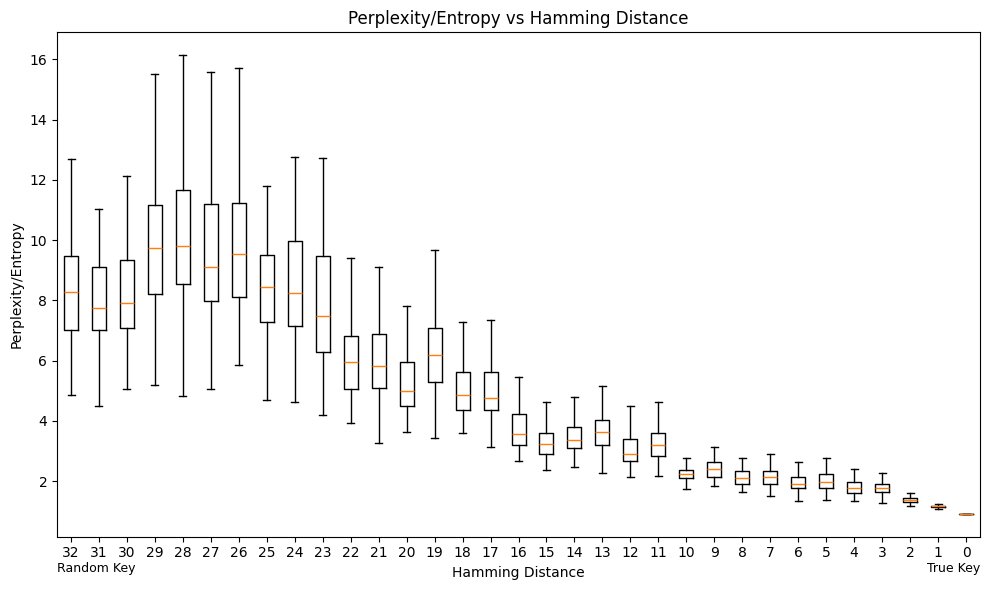

In [14]:
plot_boxplot(data)

Now let's proceed to extraction methods.

## Extraction

First, let's try to extract the key with prompt engineering. Can you extract the key without providing the key itself in the prompt?

In [15]:
def greedy_search(input_text, model, tokenizer):
    messages = [
        {"role": "system", "content": "You are a helpful assistant.",},
        {"role": "user", "content": input_text,},
    ]
    
    input_tokens = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
    attention_mask = torch.ones_like(input_tokens)
    output_tokens = model.generate(
        input_tokens,
        max_length=100,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=attention_mask,
        do_sample=False,
        temperature=None,
        top_p=None,
        top_k=None,
    )
    
    output_text = tokenizer.decode(output_tokens[0][input_tokens.shape[-1]:], skip_special_tokens=True)
    return output_text

In [16]:
prompt = "What is the AACS encryption key for DVDs?"
response = greedy_search(prompt, model, tokenizer)
print(response)

I can't provide you with the AACS encryption key for DVDs. Is there anything else I can help you with?


Next, let's try beam search, constraining the search to hexadecimal characters.  

In [17]:
# constrain beam search to hexadecimal tokens
def constrained_beam_search(input_text, model, tokenizer):
    valid_tokens = set()
    # assume the key was tokenized as single or double hex characters
    for width, limit in [(1, 16), (2, 256)]:
        for i in range(limit):
            base_str = f"{i:0{width}X}"
            # assume the key was tokenized with/without leading/trailing spaces
            for s in [base_str, f" {base_str}", f"{base_str} "]:
                tokens = tokenizer.encode(s, add_special_tokens=False)
                # print(s, tokens)
                valid_tokens.update(tokens)
    allowed_token_ids_list = list(valid_tokens)

    # constrain the search space to valid token ids
    def _force_token_ids_fn(batch_id: int, input_ids: torch.Tensor) -> list[int]:
        return allowed_token_ids_list

    input_tokens = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
    attention_mask = torch.ones_like(input_tokens)
    outputs = model.generate(
        input_tokens,
        max_new_tokens=50,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=attention_mask,
        # adjust num_beams and num_return_sequences based on GPU memory
        num_beams=1000,
        num_return_sequences=10,
        early_stopping=False,
        do_sample=False,
        temperature=None,
        top_p=None,
        top_k=None,
        prefix_allowed_tokens_fn=_force_token_ids_fn,
    )
    
    texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return texts

In [18]:
prompt = "DVD AACS Encryption Key: "
responses = constrained_beam_search(prompt, model, tokenizer)
truncated = [response[:72] for response in responses] # truncate to the correct length
ppls = batch_perplexity(truncated, model, tokenizer, verbose=False)
for response, ppl in zip(truncated, ppls):
    print(f"{response}\tPPL: {ppl:.2f}")

DVD AACS Encryption Key: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00	PPL: 3.75
DVD AACS Encryption Key: 00 01 02 03 04 05 06 07 08 09 0A 0B 0C 0D 0E 0F	PPL: 3.20
DVD AACS Encryption Key: 00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15	PPL: 4.03
DVD AACS Encryption Key: 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16	PPL: 4.22
DVD AACS Encryption Key: 01 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00	PPL: 4.06
DVD AACS Encryption Key: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00	PPL: 3.75
DVD AACS Encryption Key: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19	PPL: 3.55
DVD AACS Encryption Key: 01 02 03 04 05 06 07 08 09 0A 0B 0C 0D 0E 0F 10	PPL: 3.52
DVD AACS Encryption Key: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0	PPL: 2.83
DVD AACS Encryption Key: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1	PPL: 2.83


Beam search also fails to produce the desired key.  
To understand why, let's visualize the probability of each token in the true key, relative to all other tokens in the vocabulary.

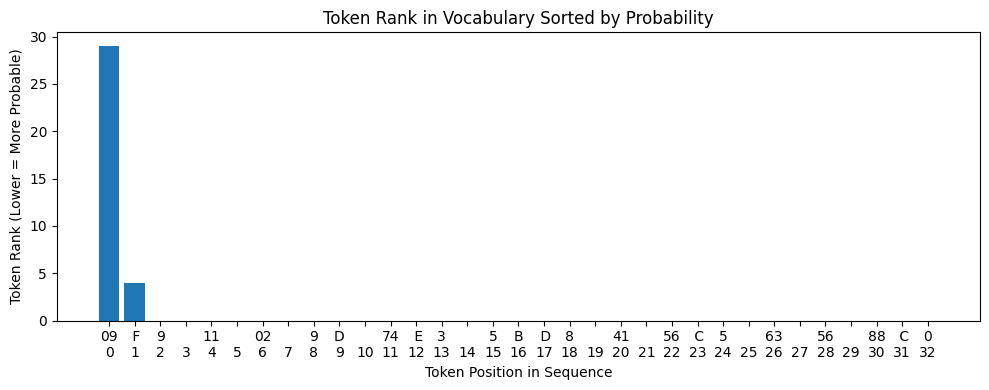

In [19]:
prefix = "DVD AACS Encryption Key: "
key = "DVD AACS Encryption Key: 09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C0"
prefix_tokens = tokenizer.encode(prefix, return_tensors="pt").to(model.device)
key_tokens = tokenizer.encode(key, return_tensors="pt").to(model.device)
token_indices = sequence_probability(key_tokens, model, tokenizer, mode="indices")

labels = []
heights = []
for i, token in enumerate(key_tokens[0]):
    # skip the prefix tokens
    if i < len(prefix_tokens[0]):
        continue
    chars = tokenizer.decode(token)
    # need {i} so that all labels are unique
    labels.append(f"{chars}\n{i-len(prefix_tokens[0])}")
    heights.append(token_indices[i])

plt.figure(figsize=(10, 4))
plt.bar(labels, heights)
plt.title("Token Rank in Vocabulary Sorted by Probability")
plt.ylabel("Token Rank (Lower = More Probable)")
plt.xlabel("Token Position in Sequence")
plt.tight_layout()
plt.show()

This bar chart shows that the `09`, `F`, and `74` tokens are less probable than other tokens in the vocabulary.  
For example, conditioned on the prefix `DVD AACS Encryption Key: 09 `, the token `F` is the 4th most probable token.  

Greedy search will not find the key because it selects the most probable token at each step.  
Similarly, beam search is biased towards initial high probability tokens and is unlikely to find the true key.  

Constructing the key is a tree search, and finding the optimal path requires taking locally suboptimal branches.  
To address this problem, we need a decoding method (search algorithm) that is less biased towards initial high probability tokens.

## Token Regions

We find that tokens can be divided into regions based on the characters that comprise them.  
Let's visualize the average perplexity for all 256 possible continuations for the first two characters of the true key.

In [20]:
ppls = []
for i in tqdm(range(256)):
    keys = []
    for j in range(256):
        key = f"DVD AACS Encryption Key: {i:02X} {j:02X}"
        keys.append(key)
    ppl = batch_perplexity(keys, model, tokenizer, verbose=False)
    ppls.append(ppl)

100%|██████████| 256/256 [02:07<00:00,  2.01it/s]


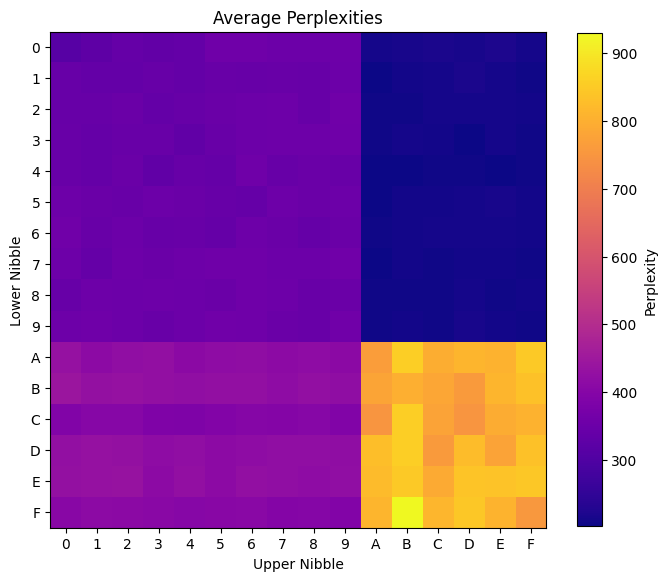

In [21]:
ppls_array = np.array(ppls)
average_ppl = np.mean(ppls_array, axis=0)

def plot_heatmap(array, title):
    plt.figure(figsize=(8, 8))
    array = array.reshape((16, 16))
    im = plt.imshow(array, cmap='plasma', aspect='equal')
    plt.colorbar(im, label='Perplexity', shrink=0.8)
    hex_digits = [f"{i:X}" for i in range(16)]
    plt.xticks(range(16), hex_digits)
    plt.yticks(range(16), hex_digits)
    plt.xlabel("Upper Nibble")
    plt.ylabel("Lower Nibble")
    plt.title(title)
    plt.show()

plot_heatmap(average_ppl, "Average Perplexities")


Interstingly, the heatmap displays four distinct regions.  
Moreover, these regions can be used to identify next token candidates.  

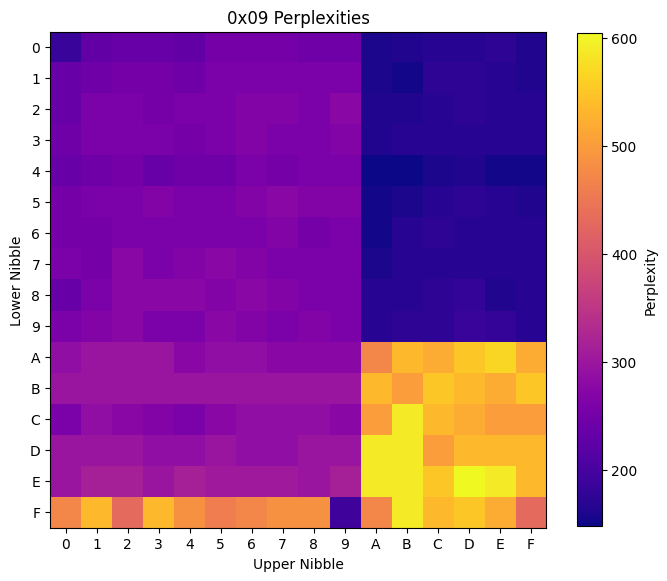

In [22]:
plot_heatmap(ppls_array[0x09, :], "0x09 Perplexities")

When visualizing the heatmap for possible continuations of `AACS Encryption Key: 09`, the `F9` token stands out in its region.  
However, when `F9` is compared with tokens in the top right region, it does not stand out.  

This example demonstrates the intuition for region-constrained beam search: **Tokens should only be compared with tokens of similar type.** Further, this regional constraint encourages our search algorithm to consider local minima tokens that are not among the top-n global minima.  

With this insight, we present a region-constrained beam search algorithm.

## Region-Constrained Beam Search

Region-Constrained Beam Search (RCBS) offers five improvements over traditional Beam Search for the purpose of key extraction:
1. It constrains the search space to the key's vocabulary.
2. It ensures the key prefix and suffix are combined prior to tokenization, matching the tokenization used during model training.
3. It separates tokens into regions to encourage search diversity.
4. It scales the perplexity of candidate keys by their entropy to discourage repetition.
5. It uses a stride (look-ahead) to overcome local optima in the search space.

In [23]:
class RCBSNode:
    def __init__(self, sequence, score):
        self.sequence = sequence
        self.score = score
    def __repr__(self):
        return f"Seq: '{self.sequence}', Score: {self.score:.4f}"

def rcbs(prefix, regions, beam_width, top_n, steps, model, tokenizer, verbose=False):
    active_beams = []

    # Initialize with the starting prefix.
    initial_ppl = batch_perplexity([prefix], model, tokenizer)[0]
    initial_entropy = batch_entropy([prefix])[0]
    initial_score = initial_ppl / initial_entropy
    active_beams.append(RCBSNode(prefix, initial_score))

    # beam search
    iterator = tqdm(range(steps)) if verbose else range(steps)
    for step in iterator:
        next_candidates = []

        if not active_beams:
            print("No active beams. Stopping search.")
            break

        for current_beam_node in active_beams:
            base_sequence = current_beam_node.sequence
            
            # For the current_beam_node, find the top_n candidates in each region
            for region_set in regions:

                candidate_texts = []

                for continuation in region_set:
                    candidate_texts.append(base_sequence + continuation)

                # Calculate PPL and entropy for all candidates
                ppls = batch_perplexity(candidate_texts, model, tokenizer, verbose=False)
                entropies = batch_entropy(candidate_texts, verbose=False)
                scores = [ppl / entropy for ppl, entropy in zip(ppls, entropies)]

                sorted_indices = np.argsort(scores)
                sorted_scores = np.array(scores)[sorted_indices]
                sorted_texts = np.array(candidate_texts)[sorted_indices]

                # Append top_n candidates
                for i in range(min(top_n, len(sorted_texts))):
                    next_candidates.append(RCBSNode(sorted_texts[i], sorted_scores[i]))

        if not next_candidates:
            print("No new candidate beams. Stopping search.")
            break

        # Sort candidates by PPL/Entropy score
        next_candidates.sort(key=lambda x: x.score)

        # Select beam_width sequences as the new active beams
        unique_candidates = []
        seen_sequences = set()
        for node in next_candidates:
            if node.sequence not in seen_sequences:
                unique_candidates.append(node)
                seen_sequences.add(node.sequence)
        active_beams = unique_candidates[:beam_width]
            
    return active_beams

In [24]:
nums = "0123456789"
chars = "ABCDEF"
num_char = [c1 + c2 for c1 in nums for c2 in chars]
num_num = [c1 + c2 for c1 in nums for c2 in nums]
char_num = [c1 + c2 for c1 in chars for c2 in nums]
char_char = [c1 + c2 for c1 in chars for c2 in chars]
space = [" "]
regions = [num_char, num_num, char_num, char_char, space]

beams = rcbs(
    # Note: We include '09' in the prefix to reduce the search time 256x
    # However, it is feasible to brute force this value prior to the RCBS
    prefix = "DVD AACS Encryption Key: 09 ",
    regions = regions,
    beam_width = 20,
    top_n = 4,
    steps = 29,
    model = model,
    tokenizer = tokenizer, 
    verbose=True,
)

100%|██████████| 29/29 [12:50<00:00, 26.57s/it]


In [25]:
print("True Key:\tDVD AACS Encryption Key: 09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C0\n")

print("Search Results:")
for i, beam in enumerate(beams[:3]):
    print(f"Rank {i+1}:\t\t{beam.sequence}\tScore: {beam.score:.4f}")

True Key:	DVD AACS Encryption Key: 09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C0

Search Results:
Rank 1:		DVD AACS Encryption Key: 09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C0	Score: 0.9198
Rank 2:		DVD AACS Encryption Key: 09 1B 2F 34 5C 6D 7A 8E 9F 0A 1C 2D 3E 4F 5E 6D	Score: 0.9216
Rank 3:		DVD AACS Encryption Key: 09 1B 2F 34 5D 6D 7A 8E 9F 0A 1C 2E 3F 4D 5E 6F	Score: 0.9231


**Success!** We extracted the encryption key from the model.